In [1]:
from keras.applications import VGG16
import os,sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import optimizers
import time
import glob
import cv2

Using TensorFlow backend.
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\anaconda3\envs\rebuild_keras\lib\site-packages\tensorflo

In [2]:
from keras import backend as K

if 'tensorflow' == K.backend():
    import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [3]:
folder = os.listdir("./data/SDNET2018/D/")
image_size = 256
dense_size = len(folder)

X = []
Y = []
for index, name in enumerate(folder):
    dir = "./data/SDNET2018/D/" + name
    files = glob.glob(dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0


Y = np_utils.to_categorical(Y, dense_size)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

batch_size = 64
nb_epoch = 100

In [4]:
#VGG16のロード。FC層は不要なので　include_top=False
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))

#FC層の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(dense_size, activation='softmax'))

#VGG16とFC層を結合してモデルを作成
vgg_model = Model(input=vgg16.input, output=top_model(vgg16.output))

#最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
        layer.trainable = False
        
#多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
        metrics=['accuracy'])

c:\anaconda3\envs\rebuild_keras\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  if sys.path[0] == '':


In [5]:
#EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1)

#ModelCheckpoint
result_dir = './result_dir/'
if os.path.exists(result_dir)==False:os.mkdir(result_dir)
model_checkpoint = ModelCheckpoint(
    result_dir + "val_loss[val_loss:.3f].hd5f",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    period = 3)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

#log for TensorBoard
log_dir = './log_dir/'
if os.path.exists(log_dir)==False:os.mkdir(log_dir)
logging = TensorBoard(log_dir)

In [6]:
#Fine-tuning
hist = vgg_model.fit(
    X_train,y_train,
    verbose=1,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, logging]
    )


c:\anaconda3\envs\rebuild_keras\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 8716 samples, validate on 2180 samples
Epoch 1/100
8716/8716 [==============================] - 89s 10ms/step - loss: 0.4377 - acc: 0.8448 - val_loss: 0.3641 - val_acc: 0.8679
Epoch 2/100
8716/8716 [==============================] - 40s 5ms/step - loss: 0.3583 - acc: 0.8738 - val_loss: 0.3163 - val_acc: 0.8917
Epoch 3/100
8716/8716 [==============================] - 40s 5ms/step - loss: 0.3205 - acc: 0.8919 - val_loss: 0.2872 - val_acc: 0.9037
Epoch 4/100
8716/8716 [==============================] - 40s 5ms/step - loss: 0.3066 - acc: 0.9004 - val_loss: 0.2749 - val_acc: 0.9073
Epoch 5/100
8716/8716 [==============================] - 41s 5ms/step - loss: 0.3037 - acc: 0.9021 - val_loss: 0.2820 - val_acc: 0.9032
Epoch 6/100
8716/8716 [==============================] - 40s 5ms/step - loss: 0.2779 - acc: 0.9075 - val_loss: 0.2608 - val_acc: 0.9151
Epoch 7/100
8716/8716 [==============================] - 41s 5ms/step - loss: 0.2695 - acc: 0.9111 - val_loss: 0.2597 - val_acc: 0.9170

In [7]:
model_dir = './model/'
if os.path.exists(model_dir) == False:os.mkdir(model_dir)

vgg_model.save(model_dir + 'model_SDNET2018_256.hdf5')

# optimizerのない軽量モデルを保存（学習や評価は不可だが、予測は可能）
#vgg_model.save(model_dir + 'model-opt.hdf5', include_optimizer = False)

# ベストの重みのみ保存
weights_dir = './weights_dir/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
vgg_model.save_weights(weights_dir + 'model_weight_SDNET_256.hdf5')

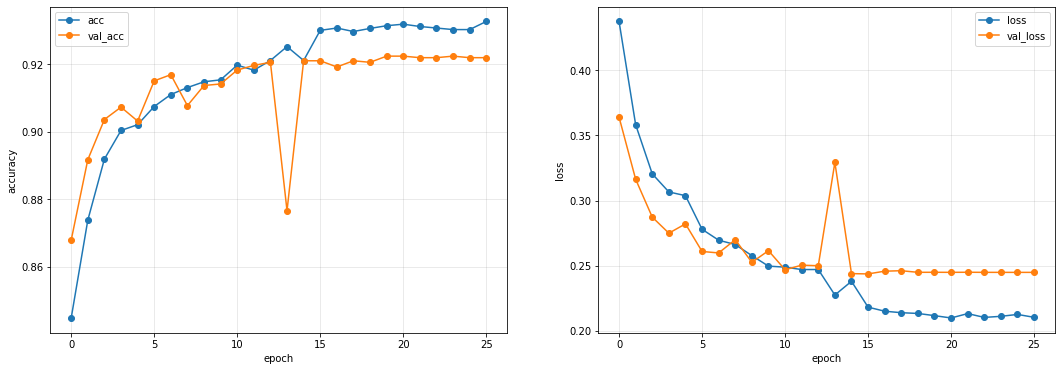

In [8]:
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label = "acc", marker = "o")
plt.plot(hist.history["val_acc"], label = "val_acc", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss", marker = "o")
plt.plot(hist.history["val_loss"], label = "val_loss", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

plt.show()

In [15]:
score = vgg_model.evaluate(X_test,y_test,verbose=1)
print("evaluate loss: {0[0]}".format(score))
print("evaluate acc: {0[1]}".format(score))

prex = vgg_model.predict(X_test)
wrong = []
w_index = []
fp = []
fn = []
a = np_utils.to_categorical(1, dense_size)
for i in range(len(X_test)):
    yi = y_test[i:i+1]
    prei = prex[i:i+1]
    if prei.argmax() != yi.argmax():
        wrong.append(i)
        w_index.append(y_test[i])
        if y_test[i][0] == a[0]:
            fp.append(i)
        elif y_test[i][0] == a[1]:
            fn.append(i)
wrong = np.array(wrong)   
wrong.astype('float32')
w_index = np.array(w_index)

2724/2724 [==============================] - 10s 4ms/step
evaluate loss: 0.21982969183928816
evaluate acc: 0.9254772393538914


In [16]:
print(fp)
print('fp', len(fp))
print(fn)
print('fn', len(fn))
#print(w_index)
print('wrong',len(wrong))
#print(y_test[3][1])

[60, 231, 242, 297, 319, 350, 494, 561, 609, 684, 687, 689, 763, 785, 796, 1018, 1057, 1091, 1157, 1183, 1188, 1302, 1309, 1570, 1624, 1634, 1643, 1659, 1676, 1924, 1927, 2058, 2150, 2183, 2186, 2188, 2196, 2393, 2462, 2631]
fp 40
[7, 14, 16, 26, 43, 55, 63, 65, 69, 79, 119, 122, 136, 143, 144, 213, 232, 265, 291, 293, 326, 341, 342, 362, 380, 383, 389, 412, 431, 437, 446, 456, 464, 465, 478, 524, 551, 552, 560, 574, 589, 627, 631, 685, 686, 703, 747, 771, 814, 834, 845, 864, 880, 887, 888, 908, 921, 923, 932, 941, 947, 977, 1040, 1067, 1070, 1090, 1139, 1177, 1181, 1270, 1277, 1285, 1312, 1313, 1316, 1355, 1366, 1380, 1390, 1399, 1400, 1410, 1421, 1426, 1437, 1462, 1471, 1473, 1486, 1493, 1517, 1529, 1530, 1584, 1610, 1618, 1638, 1642, 1682, 1689, 1716, 1732, 1742, 1783, 1819, 1855, 1866, 1887, 1919, 1938, 1942, 1954, 1956, 1995, 1999, 2006, 2039, 2048, 2063, 2082, 2085, 2094, 2097, 2106, 2144, 2160, 2162, 2185, 2210, 2220, 2246, 2254, 2269, 2290, 2296, 2297, 2307, 2314, 2315, 2330, 2

In [18]:
fp_dir = './data/fp_learning_256/'
fn_dir = './data/fn_learning_256/'
if os.path.exists(fp_dir)==False:os.mkdir(fp_dir)
if os.path.exists(fn_dir)==False:os.mkdir(fn_dir)
    
for i in range(len(fp)):
    im = (X_test[fp[i]]*255)
    img = Image.fromarray(np.uint8(im))
    img.save(fp_dir + '{}.jpg'.format(i))
    
for i in range(len(fn)):
    im = (X_test[fn[i]]*255)
    img = Image.fromarray(np.uint8(im))
    img.save(fn_dir + '{}.jpg'.format(i))

In [27]:
crack = []
files = glob.glob("./data/crack/*.jpg")
for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        crack.append(data)
crack = np.array(crack)
crack = crack.astype('float32')
crack = crack / 255.0

In [32]:
predict = vgg_model.predict(crack)
print(">> 計算結果↓\n" + str(predict))
#print(">>　この画像は「"+)
#print(predict)print(w_index[106])
fig = plt.figure(figsize=(16,9))
plt.imshow(X[wrong[106]])
plt.show()

[[9.80705678e-01 1.92943756e-02]
 [9.97598350e-01 2.40159128e-03]
 [9.99907970e-01 9.19750237e-05]
 [1.00000000e+00 1.31607969e-09]
 [9.88109410e-01 1.18905585e-02]
 [9.99911427e-01 8.85772606e-05]
 [1.00000000e+00 2.70869460e-09]
 [1.00000000e+00 1.18646950e-08]]


In [1]:
print(fp[1])
fig = plt.figure(figsize=(16,9))
plt.imshow(X[wrong[1]])
plt.show()

NameError: name 'fp' is not defined